In [1]:
import os
import ast
import textwrap
import tiktoken
import keyboard
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv, find_dotenv
from typing import Optional

In [2]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings()

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)

# Eliminar la primera página o portada del doc.

In [7]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./docs/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

In [8]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

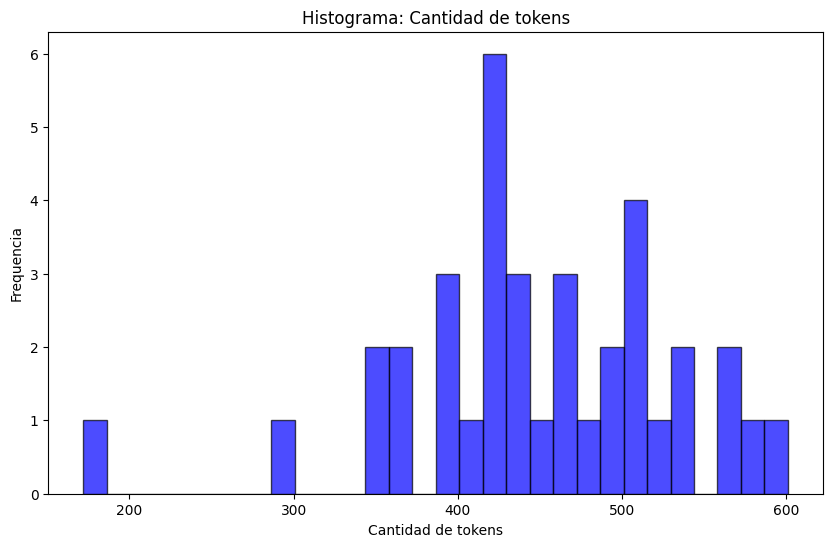

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.show()

In [10]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 16668


# 1. ¿Incrustar de cero?
# 2. ¿Elegir un encrustamiento guardado?

In [11]:
user_input = input("Elige 1 o 2: ")

if user_input.lower() == "1":
    print('Elegiste 1')
    global_embeddings = [embeddings.embed_query(txt) for txt in texts]

    embed_name = input('¿Cómo se llama esta incrustación?: ') + '_emb' + '.txt'
    with open(rf'./embed/{embed_name}', 'w') as f:
        for i in global_embeddings:
            f.write("%s\n" % i)
    
elif user_input.lower() == "2":
    print('Elegiste 2')
    global_embeddings = []

    embed_name = input('Nombre del encrustamiento: ') + '_emb' + '.txt'

    with open(rf'./embed/{embed_name}', 'r') as f:
        for i in f:
            x = ast.literal_eval(i.strip())  # Convertir la cadena a lista de números
            global_embeddings.append(x)

    global_embeddings = np.array(global_embeddings, dtype=float)
    
elif user_input != "1" and user_input != "2":
    print("No seleccionaste ningún encrustamiento.")

Elegiste 1


In [12]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

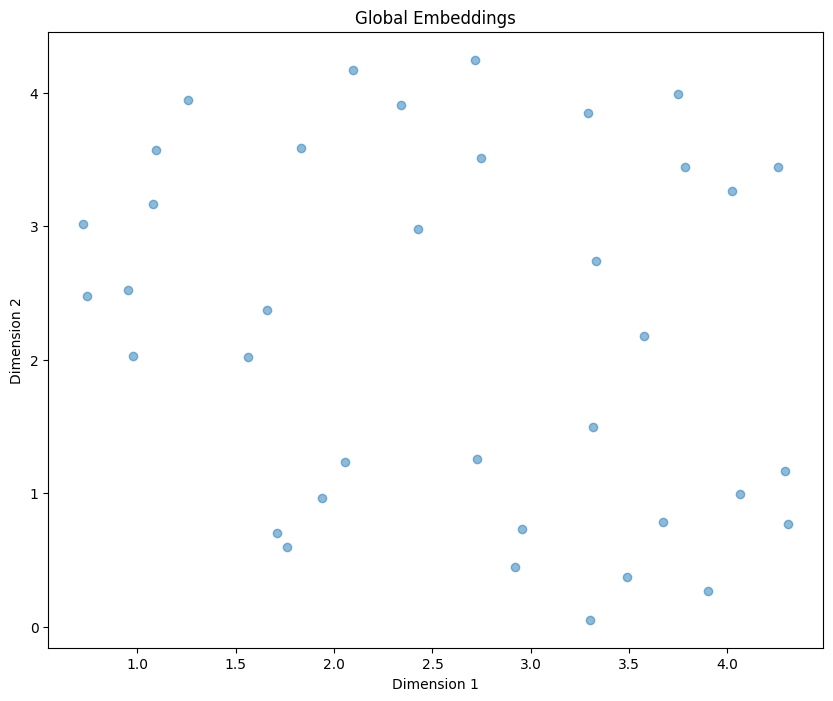

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


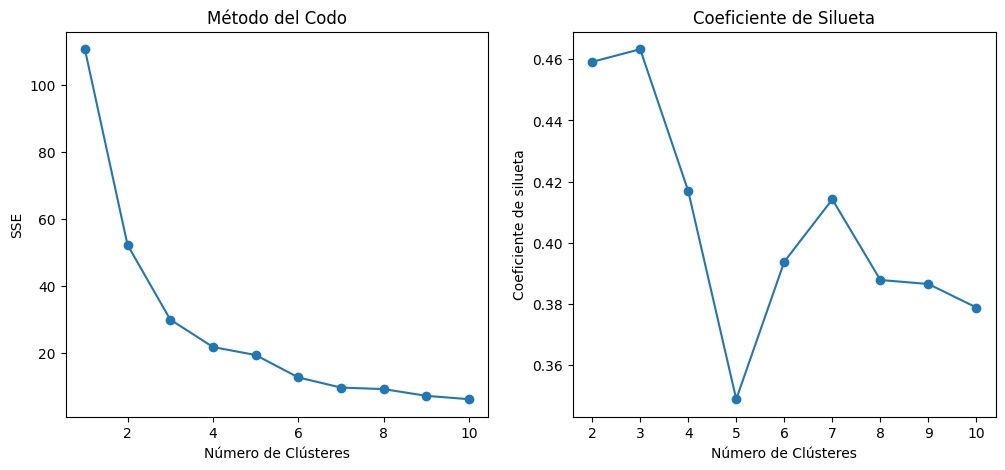

Número óptimo de clústeres según el método del codo: 1
Número óptimo de clústeres según el coeficiente de silueta: 3


In [14]:
# Método del Codo
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    sse.append(kmeans.inertia_)

# Coeficiente de Silueta
silhouette_scores = []
for k in k_values[1:]:  # Silhouette score no está definido para k=1
    kmeans = KMeans(n_clusters=k, random_state=0).fit(global_embeddings_reduced)
    score = silhouette_score(global_embeddings_reduced, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE')

# Graficar el coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(k_values[1:], silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clústeres')
plt.ylabel('Coeficiente de silueta')
plt.show()

# Determinación del número óptimo de clústeres
optimal_k_elbow = np.argmin(np.diff(sse)) + 1  # Codo
optimal_k_silhouette = k_values[1:][np.argmax(silhouette_scores)]  # Silueta

print(f"Número óptimo de clústeres según el método del codo: {optimal_k_elbow}")
print(f"Número óptimo de clústeres según el coeficiente de silueta: {optimal_k_silhouette}")

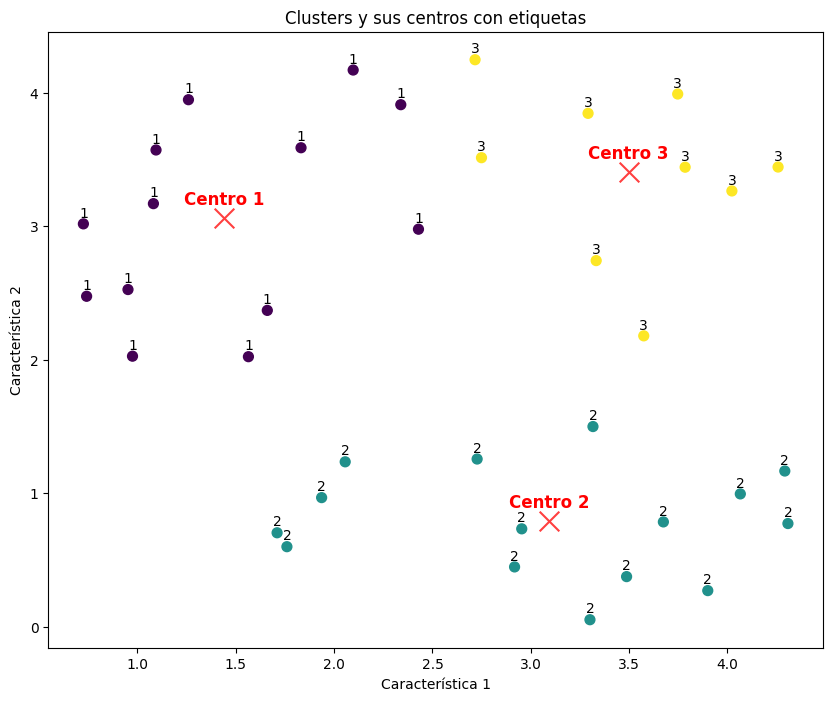

In [15]:
# Suponiendo que 'global_embeddings_reduced' ya está definido
optimal_k = input('¿Cuántos clústeres quiere usar?: ')

kmeans = KMeans(n_clusters=int(optimal_k), random_state=0).fit(global_embeddings_reduced)
labels = kmeans.labels_ + 1  # Agregar 1 a las etiquetas de los clústeres
centers = kmeans.cluster_centers_

# Visualizar los datos y los centros de los clústeres
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

# Añadir etiquetas a los puntos de datos
for i in range(len(global_embeddings_reduced)):
    plt.annotate(str(labels[i]), (global_embeddings_reduced[i, 0], global_embeddings_reduced[i, 1]),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Añadir etiquetas a los centros de los clústeres
for i, center in enumerate(centers):
    plt.annotate(f'Centro {i+1}', (center[0], center[1]), textcoords="offset points", xytext=(0,10), ha='center', color='red', fontsize=12, weight='bold')

plt.title("Clusters y sus centros con etiquetas")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

# Aplicar análisis a base de datos para determinar de qué habla (tema principal) cada clúster.

In [16]:
df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': labels
})
df.head()
doc_nom = input('Ingrese el nombre del documento')
df.to_csv(f'{doc_nom}.csv', sep=';', encoding='utf-8-sig')

In [17]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{2: 'See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/364350695 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca Chapt er · Dec ember 2021 CITATIONS 0READS 26 2 author s, including: Isabel Cristina Quint ero Univ ersidad P ontificia Boliv ariana 32 PUBLICA TIONS \xa0\xa0\xa031 CITATIONS \xa0\xa0\xa0 SEE PROFILE All c ontent f ollo wing this p age was uplo aded b y Isabel Cristina Quint ero on 18 Oct ober 2022. The user has r equest ed enhanc ement of the do wnlo aded file. --- 73 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca ESTRATEGIAS PARA FORTALECER LAS  CAPACIDADES DE INNOV ACIÓN EN EMPRESAS DEL  CLÚSTER DE LA CAÑA EN EL V ALLE DEL CAUCA Edwin Fernando Montoya3 Isabel Cristina Quintero Sepúlveda4 Resumen La innovación está asociada a las dinámicas económicas y sociales, por lo que 

In [18]:
template = """Eres un revisor bibliográfico profesional encargado de crear resúmenes extremadamente detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [19]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{2: 'Este estudio se centra en las estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca. La innovación se considera crucial para el desarrollo productivo y la transformación del conocimiento científico y tecnológico en riqueza económica, bienestar social y desarrollo humano. Se analizan tres casos empresariales en el clúster de la caña de azúcar en el Valle del Cauca, identificando las capacidades de innovación y proponiendo acciones estratégicas para mejorar dichas capacidades y los resultados de innovación.\n\nSe destaca la importancia de los clústeres como concentraciones geográficas de empresas e instituciones conectadas entre sí, y se menciona la relevancia de la ubicación para la ventaja competitiva en una economía globalizada. Colombia ha avanzado poco en competitividad, especialmente en capacidad de innovación. Se señala que el 21.7% de las empresas industriales y el 22.7% del sector servicios se consideran innovador

In [20]:
clustered_summaries = {}
for label, summary in zip(labels, summaries.values()):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(summary)

clustered_summaries

{2: ['Este estudio se centra en las estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca. La innovación se considera crucial para el desarrollo productivo y la transformación del conocimiento científico y tecnológico en riqueza económica, bienestar social y desarrollo humano. Se analizan tres casos empresariales en el clúster de la caña de azúcar en el Valle del Cauca, identificando las capacidades de innovación y proponiendo acciones estratégicas para mejorar dichas capacidades y los resultados de innovación.\n\nSe destaca la importancia de los clústeres como concentraciones geográficas de empresas e instituciones conectadas entre sí, y se menciona la relevancia de la ubicación para la ventaja competitiva en una economía globalizada. Colombia ha avanzado poco en competitividad, especialmente en capacidad de innovación. Se señala que el 21.7% de las empresas industriales y el 22.7% del sector servicios se consideran innovado

In [21]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{2: 'El estudio se enfoca en las estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca. Se destaca la importancia de la innovación para el desarrollo productivo y la transformación del conocimiento en riqueza económica y desarrollo humano. Se analizan tres casos empresariales en el clúster de la caña de azúcar, identificando capacidades de innovación y proponiendo acciones estratégicas para mejorar dichas capacidades y los resultados de innovación.\n\nSe resalta la importancia de los clústeres como concentraciones geográficas de empresas e instituciones conectadas entre sí, y se menciona la relevancia de la ubicación para la ventaja competitiva en una economía globalizada. Colombia ha avanzado poco en competitividad, especialmente en capacidad de innovación. Se señala que un porcentaje significativo de empresas se consideran innovadoras, con recursos propios como principal fuente de financiación.\n\nEn el clúster de la caña d

In [22]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [23]:
combined_texts[:10]

['See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/364350695 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca Chapt er · Dec ember 2021 CITATIONS 0READS 26 2 author s, including: Isabel Cristina Quint ero Univ ersidad P ontificia Boliv ariana 32 PUBLICA TIONS \xa0\xa0\xa031 CITATIONS \xa0\xa0\xa0 SEE PROFILE All c ontent f ollo wing this p age was uplo aded b y Isabel Cristina Quint ero on 18 Oct ober 2022. The user has r equest ed enhanc ement of the do wnlo aded file.',
 '73 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca ESTRATEGIAS PARA FORTALECER LAS  CAPACIDADES DE INNOV ACIÓN EN EMPRESAS DEL  CLÚSTER DE LA CAÑA EN EL V ALLE DEL CAUCA Edwin Fernando Montoya3 Isabel Cristina Quintero Sepúlveda4 Resumen La innovación está asociada a las dinámicas económicas y sociales, por lo que tra

In [24]:
# Nombre del archivo de texto
file_name = "final_test.txt"

# Escribir la lista en el archivo de texto
with open(file_name, 'w', encoding='utf-8') as f:
    for t in combined_texts:
        f.write("%s\n" % t)

# Leer el contenido del archivo y mostrarlo
with open(file_name, 'r', encoding='utf-8') as f:
    content = f.read()

textos = text_splitter.split_text(content)

# Guardar los kb en una carpeta (kbs)

### 1. Enseñar

In [25]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=textos,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [26]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

20


In [27]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisión biliográfica que habla Español.

Tu tarea consiste en:

1. Leer detalladamente la información proporcionada en documentos que generalmente son
artículos científicos en formato PDF.

2. Proporcionar respuestas extremadamente detalladas a cualquier tipo de pregunta relacionada 
con el contexto, especialmente a preguntas específicas. Evita concluir tus respuestas con un 
párrafo que comience con 'En resumen,...'. Varía las conclusiones de tus respuestas para que 
sean más diversas y creativas.

3. Ser carismático y ofrecer información sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables específicamente del contexto.

NUNCA terminar las respuestas con un resumen o una conclusión predecible.

Teniendo en cuenta TODO lo anterior, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain
)

In [28]:
def wrap_text_preserve_newlines(text, width=70):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['answer']))
    print('\nReferencias:')
    for contexto in llm_response["context"][:5]:
        print(contexto)

In [29]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuáles son los objetivos del documento?
Los objetivos del documento son identificar y medir las capacidades de
innovación de las empresas del clúster de la caña en el Valle del
Cauca, así como generar recomendaciones estratégicas para fortalecer
dichas capacidades. También se busca analizar las actividades de
innovación realizadas por las empresas en el periodo 2017-2019,
identificar las áreas de mejora en relación a la asignación de
recursos, la capacidad de producción, la capacidad de I+D, la
capacidad de comercialización, la capacidad de aprendizaje y la
capacidad de organización.

Referencias:
page_content='Se identifican las capacidades de innovación en las empresas participantes, estableciendo niveles de desempeño alto, medio y bajo para cada una de las capacidades analizadas. Se discuten las limitantes de la investigación, como el número limitado de empresas participantes y la dificultad de acceso debido a la pandemia.\n\nFinalmente, se plantean recomendaciones para fortalecer 

In [30]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuál es la metodología usada en el documento?
La metodología utilizada en el documento es cuantitativa descriptiva,
con corte transversal. Se empleó un cuestionario basado en el modelo
de Yam (2004) para identificar las capacidades de innovación de las
empresas participantes, el cual fue validado y probado en el proyecto
principal. Esta metodología permitió generar información relevante
para la toma de decisiones en las organizaciones, especialmente en el
ámbito de la innovación como estrategia para la sofisticación de
productos y servicios en el sector del clúster de la caña en el Valle
del Cauca.

Referencias:
page_content='77 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca sus capacidades de innovación, para luego proponer un marco de acciones estraté- gicas para el fortalecimiento de las capacidades de innovación. La metodología es cuantitativa descriptiva, con corte transversal. El instrumento para identificar las

In [31]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuáles son las conclusiones a las que llega el estudio?
El estudio concluye que las empresas del clúster de la caña en el
Valle del Cauca presentan diferentes niveles de desarrollo en sus
capacidades de innovación. La empresa A muestra un bajo nivel de
desarrollo en todas las capacidades, la empresa B tiene un nivel medio
y la empresa C cuenta con un alto nivel de desarrollo. Se destaca que
las empresas que han logrado mayores niveles de innovación y
diversificación de productos presentan mejores resultados en sus
niveles de desempeño. Además, se resalta la importancia de seguir
fortaleciendo las capacidades de innovación a través de estrategias
que promuevan la colaboración interdisciplinaria, la inversión en I+D,
la gestión eficiente de recursos y el aprendizaje continuo para
impulsar el desarrollo de nuevas ideas y soluciones innovadoras que
contribuyan al crecimiento y competitividad de las empresas del
clúster de la caña en el Valle del Cauca.

Referencias:
page_content='105 Estr

In [32]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Quiénes son los autores del documento, dónde se escribió y en qué fecha?
Los autores del documento son Edwin Fernando Montoya e Isabel Cristina
Quintero Sepúlveda. El documento fue escrito en la Universidad
Pontificia Bolivariana en Palmira, Colombia. La fecha en la que se
escribió no está especificada en el contexto proporcionado.

Referencias:
page_content='INNOV ACIÓN ORGANIZACIONAL: Experiencias y reflexiones del Valle del Cauca y Quindío.86 de datos de la Cámara de Comercio de Palmira (2019). Se identificaron los cargos  que podrían tener la información requerida para los objetivos de la investigación, se envió invitación vía e-mail, y se logró la participación final de 3 empresas cuyas características generales se describen en la Tabla 4. Tabla 4. Características generales de las empresas Empresa A Empresa B Empresa C Ciudad Florida Pradera Candelaria Codigo CIIU 161 1542 c1071 Startup No No Sí Procedencia Capital Nacional Mixto Nacional Cantidad Empleados 51-200 Mayor a 200 May

In [33]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿De qué trata el modelo de capacidades de innovación en el documento?
El modelo de capacidades de innovación en el documento se centra en
identificar y medir las capacidades de aprendizaje, I+D, gestión de
recursos, producción, mercadeo, organización y estratégica de las
empresas del clúster de la caña en el Valle del Cauca. Estas
capacidades son fundamentales para el éxito competitivo de una empresa
y su capacidad de innovar en productos, procesos y servicios. El
modelo propuesto por Guan & Ma (2003) y Yam et al. (2004) busca
evaluar el nivel de desarrollo de cada una de estas capacidades en las
empresas participantes, estableciendo niveles de desempeño alto, medio
y bajo para cada una de ellas. Además, se busca promover la
colaboración interdisciplinaria, la inversión en I+D, la gestión
eficiente de recursos y el aprendizaje continuo como estrategias para
fortalecer las capacidades de innovación en el sector del clúster de
la caña en el Valle del Cauca.

Referencias:
page_content='Se

In [34]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuáles son las capacidades de innovación que se mencionan en el documento?
Las capacidades de innovación mencionadas en el documento son:
dirección estratégica, capacidad organizacional, capacidad de
innovación, capacidad de producción, capacidad de comercialización,
gestión de recursos y capacidad de aprendizaje. Cada una de estas
capacidades se evalúa en las empresas participantes para determinar su
nivel de desarrollo en cada una de ellas. Además, se identifica la
importancia de fortalecer estas capacidades a través de estrategias
específicas para promover la innovación en las empresas del clúster de
la caña en el Valle del Cauca.

Referencias:
page_content='Se identifican las capacidades de innovación en las empresas participantes, estableciendo niveles de desempeño alto, medio y bajo para cada una de las capacidades analizadas. Se discuten las limitantes de la investigación, como el número limitado de empresas participantes y la dificultad de acceso debido a la pandemia.\n\nFinal

In [36]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿De qué trataron las innovaciones en cada empresa estudiada?
La empresa A no generó ninguna innovación en productos o servicios
durante el periodo evaluado. La empresa B realizó 2 innovaciones que
tuvieron impacto en el mercado nacional. Por otro lado, la empresa C
generó 6 innovaciones con enfoque hacia la diversificación del
portafolio de productos y nuevos procesos para mejorar la
productividad. Cada empresa enfocó sus innovaciones de manera
diferente, con resultados variables en cuanto a la cantidad y el
impacto de las mismas.

Referencias:
page_content='87 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca En la Tabla 4 se observan las actividades de innovación que han realizado las tres  empresas en el periodo 2017 – 2019. Los resultados evidencian que la empresa A, que presta servicios de apoyo a la agricultura y cuyas actividades están centradas principalmente en temas operativos realizados casi en su mayoría en el

# Hacer historial

In [ ]:
# Para archivos grandes debes dividir el texto

# # Diccionario inicial
# data = {
#     2: 'El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es un tema abordado en un estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno de la Universidad EAN. El propósito de la investigación es analizar'
# }

# # Obtener el texto original
# original_text = data[2]

# # Encontrar el punto medio
# mid_point = len(original_text) // 2

# # Definir el tamaño del solapamiento
# overlap_size = 50

# # Calcular los puntos de división con solapamiento
# start_overlap = max(mid_point - overlap_size // 2, 0)
# end_overlap = min(mid_point + overlap_size // 2, len(original_text))

# # Dividir el texto en dos partes con solapamiento
# first_half = original_text[:end_overlap]
# second_half = original_text[start_overlap:]

# # Crear nuevas llaves en el diccionario
# data[2] = first_half
# data[3] = second_half

# # Imprimir el diccionario actualizado
# print(data)